
# 1. Introduction

This notebook has been developed for the purposes of the EMPIR project “Metrology for the Factory of the Future” (Met4FoF) -  Activity A1.2.2 of the Work Package 1.Two laboratories in PTB and CEM posses conventional dynamic calibration set-ups for acceleration sensors under test. The objective of the task is to compare measurement results of the two laboratories, PTB and CEM, provided by the extended dynamic calibration systems. 

## 1.1. State of the art

In conventional dynamic calibration procedures for acceleration sensors, the acceleration used for the sensor input is applied either as **a sinusoidal excitation with a given frequency and amplitude** or as **a singular shock-like excitation characterized by pulse width and intensity**. 
<br>The quantity is then measured by a reference sensor and by the device under test (DUT). The results of DUT are compared to the reference and hence characterized and linked to the SI. In a dynamic calibration situation, the response of the DUT to time-varying input is the major interest. Hence, it is crucial that the mechanical input operates simultaneously and equally on the reference and DUT. Both, the reference and the DUT provide **electrical outputs (typical voltage)** while **the data acquisition electronics** of the system provides **the analogue to digital conversion (ADC).**
In order to connect the reference and the DUT to the ADC system, two analogue channels are needed. In order to get reliable information on the time dependent response, the timing of the data acquisition on the two channels has to be synchronized. This is typically accomplished by provision of a common clock signal to drive the sampling units of the ADC and a common trigger to start (or mark) the beginning of the acquisition. 

## 1.2. The extension of conventional dynamic calibration systems to digital-output sensors 

In a set-up where the DUT is a digital-output sensor,the sampling of the DUT time series is no longer under the control (trigger, clock) of the calibration system. Instead, the DUT comprises its own digitizer unit with a time base independent of the calibration system. In fact, a typical conventional calibration set-up does not provide an input for digital data at all.
The solution to this problem requires two extensions:
1.	A digital acquisition unit (DAU) which is capable to connect to the digital interface of the sensor under calibration and store/transmit the DUT time-series for later analysis
2.	An additional synchronization signal that provides the link between the time-base of the calibration system and the time-base of the DUT.

The concept for the extension of existing facilities for dynamic calibration uses a custom digital acquisition unit microcontroller board with a connected reference time signal for traceable time stamping of acquired data points. This allows for a synchronised data acquisition from the reference measurement and the DUT. The selected sensor for acceleration measurements is a three axial low-g acceleration sensor with digital output, which allows measurements of acceleration in three perpendicular axes.**At the moment and in this notebook, only an X-axis acceleration has been observed.** 
    
The selected laboratories posses their set-ups and the calibration items were calibrated in both set-ups.The analysis required transformation from time domain to the frequency domain, where frequencies and corresponding magnitudes and phases were calculated.The measurement conditions were kept according to the laboratory standard conditions. 

Each laboratory submitted HDFT files containing groups:
- EXPERIMENTS - containing 171 files (experiment) corresponding to the sine excitations
- RAWDATA - where data from ADCs (*voltage, absolute time, absolute time uncertainty*)  and sensors (*absolute time, absolute time uncertainty, acceleration, angular velocity, magnetic flux density and temperature*) can be approached during the measurements
- RAWTRANSFERFUNCTION - *this group contains quantities of interest: frequencies, amplitudes, assigned uncertainties of amplitudes, phases,  assigned uncertainties of phases, excitation amplitudes and assigned uncertainties of excitation amplitudes
- REFERENCEDATA - reference data from ADCs and sensors.

    
| <b>PTB<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 535035904 | 535038464 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |
    
| <b>CEM<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 3167420416 | 31674422976 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |

In [ ]:
import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats
import seaborn as sns

# 2.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data will be sorted by frequency at the end of the Notebook and saved into Excel file.

In [ ]:
def extract_data(filename, sensor_index):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250")
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_index+"_MPU_9250 items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency [Hz]", r"$x_{M},$ [m s^-2/m s^-2]",r"$U_{M},$ [m s^-2/m s^-2]", r"$x_{\phi},$ [°]", r"$U_{\phi},$ [°]","Excitation_freq [Hz]",r"$x_{Aexcit},$ [m s^-2/m s^-2]",r"$U_{Aexcit},$ [m s^-2/m s^-2]"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
        
        
        return whole_dataset

In [ ]:
whole_dataset_PTB = extract_data('MPU9250PTB_v2.hdf5',"0x1fe40000")

In [ ]:
whole_dataset_PTB.head(2)

Phase data for PTB must be reverted:

In [ ]:
whole_dataset_PTB[[r"$x_{\phi},$ [°]"]] = whole_dataset_PTB[[r"$x_{\phi},$ [°]"]]-np.pi
whole_dataset_PTB.head(2)

In [ ]:
whole_dataset_CEM = extract_data('MPU9250CEM_v2.hdf5',"0xbccb0000")

In [ ]:
whole_dataset_CEM.head(2)

Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250.Hz.

In [ ]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

In [ ]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby('Frequency [Hz]')))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [ ]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

In [ ]:
PTB_separated_by_freq.get(10).head(1)

In [ ]:
CEM_separated_by_freq.get(10).head(1)

In [ ]:
q_names=list(PTB_separated_by_freq.get(10).columns)

In [ ]:
list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]

# 3. Case study 1: Calculate En values for estimated means and standard deviations (Type A solution)

This approach neglects the calculated uncertainties of the quantities of interest from different experiments at a specific frequency and assumes that they belong to the same distribution. 

## 3.1 The probability distribution

The estimated mean values at each specific frequencies are calculated as:
$${\bar {x}}=\frac {\sum _{i=1}^{n}x_{i}}{n}$$,

where:
<br>x represents the value of an experiment at a specific frequency
<br>n is the number of experiments at a specific frequency.

The observed standard deviation of the single value is *s*, calculated as:
$$s=\sqrt{\frac {\sum _{i=1}^{n}{(x_{i}-\bar {x})}^{2}}{n-1}}$$

Estimated experimental standard deviation to the estimated mean value is:

$$s(\bar {x})=\frac {s}{\sqrt{n}}$$


Mean, observed standard deviation and estimated standard deviation to the estimated mean value of all quantities and uncertainties are calculated at every frequency by the function calculate_means_and_std.



In [ ]:
def calculate_means_and_std(dictionary,names_mean,names_std,est_names):
    mean_list=[]
    stdev_list=[]
    n_list=[]
    for val in dictionary.values():
        mean_list.append(val.mean())
        stdev_list.append(np.std(val,ddof=1))
        #new part of the code:
        n_list.append(len(val))
    mean_array=np.asarray(mean_list)
    stdev_array=np.asarray(stdev_list)
    n=np.asarray(n_list)
    mean_array=pd.DataFrame(mean_array,columns=names_mean)
    stdev_array=pd.DataFrame(stdev_array,columns=names_std)
    avg_and_std=pd.concat([mean_array,stdev_array],axis=1)
    #new part of the code
    st_dev_estimate=pd.DataFrame(stdev_array.div(np.sqrt(n),axis=0))
    st_dev_estimate.columns=est_names
    st_dev_estimate.rename(columns = {r"$s(\bar{x})$-Frequency [Hz]":"Frequency [Hz]"},inplace=True )
    return avg_and_std, st_dev_estimate


In [ ]:

column_names1=["Frequency [Hz]", r"$\bar{x}_{M},$ [m s^-2/m s^-2]",r"$\bar{x}_{U_M},$ [m s^-2/m s^-2]", r"$\bar{x}_{\phi},$ [°]", r"$\bar{x}_{U_\phi},$ [°]","Excitation_freq [Hz]",r"$\bar{x}_{Aexcit},$ [m s^-2/m s^-2]",r"$\bar{x}_{U_Aexcit},$ [m s^-2/m s^-2]"]
column_names2=["Frequency [Hz]", r"$s(x_{M}),$ [m s^-2/m s^-2]",r"$s(x_{U_M}),$ [m s^-2/m s^-2]", r"$s(x_{\phi}),$ [°]", r"$s(x_{U_\phi}),$ [°]","Excitation_freq [Hz]",r"$s(x_{Aexcit}),$ [m s^-2/m s^-2]",r"$s(x_{U_Aexcit}),$ [m s^-2/m s^-2]"]
column_names3=["Frequency [Hz]", r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]",r"$\bar{x}_{U_M},$ [m s^-2/m s^-2]", r"$s(\bar{x}_{\phi}),$ [°]", r"$\bar{x}_{U_\phi},$ [°]","Excitation_freq [Hz]",r"$s(\bar{x}_{Aexcit}),$ [m s^-2/m s^-2]",r"$\bar{x}_{U_Aexcit},$ [m s^-2/m s^-2]"]


avg_std_PTB,st_sample_PTB=calculate_means_and_std(PTB_separated_by_freq,column_names1,column_names2,column_names3)
avg_std_CEM,st_sample_CEM=calculate_means_and_std(CEM_separated_by_freq_new,column_names1,column_names2,column_names3)

st_sample_PTB["Frequency [Hz]"]=list_of_freq
st_sample_CEM["Frequency [Hz]"]=list_of_freq

avg_std_PTB .head(2)

In [ ]:
avg_std_CEM.head(2)

In [ ]:
def plot_Magnitude(dataset,mean_stdev,est_stdev,dataset1,mean_stdev1,est_stdev1):
    fig, ax = plt.subplots(nrows=len(dataset),ncols=2,figsize=(18,120))

    for i,val in enumerate(dataset.values()):
        
        x=np.linspace(0,len(val),len(val))
        y= val[ r"$x_{M},$ [m s^-2/m s^-2]"].values
        error=est_stdev[est_stdev["Frequency [Hz]"]==val["Frequency [Hz]"].values[0]]
        y1=mean_stdev[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]+mean_stdev[r"$s(x_{M}),$ [m s^-2/m s^-2]"][i]
        y2=mean_stdev[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]-mean_stdev[r"$s(x_{M}),$ [m s^-2/m s^-2]"][i]
        y3=mean_stdev[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]+est_stdev[r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]"][i]
        y4=mean_stdev[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]-est_stdev[r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]"][i]
        y5=mean_stdev[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]
        ax[i,0].errorbar(x, y,yerr=np.ones(len(val))*error[r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]"].values, linestyle="",marker="o",label="Experiments")
        ax[i,0].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$+s(x)")
        ax[i,0].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$-s(x)")
        ax[i,0].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}+s(\bar{x})$")
        ax[i,0].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}-s(\bar{x})$")
        ax[i,0].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{x}$")
        ax[i,0].set_title( str(val["Frequency [Hz]"].values[0])+" Hz - PTB")
        ax[i,0].set_ylabel("Magnitude, [m s^-2/m s^-2] ")
        ax[i,0].legend(loc="best")
        ax[i,0].fill_between(x,y1,y2,color="yellow")
        ax[i,0].fill_between(x,y3,y4,color="beige")
    
       
        
    for i,val in enumerate(dataset1.values()):
        x=np.linspace(0,len(val),len(val))
        y= val[r"$x_{M},$ [m s^-2/m s^-2]"].values
        error=est_stdev1[est_stdev1["Frequency [Hz]"]==val["Frequency [Hz]"].values[0]]
        y1=mean_stdev1[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]+mean_stdev1[r"$s(x_{M}),$ [m s^-2/m s^-2]"][i]
        y2=mean_stdev1[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]-mean_stdev1[r"$s(x_{M}),$ [m s^-2/m s^-2]"][i]
        y3=mean_stdev1[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]+est_stdev1[r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]"][i]
        y4=mean_stdev1[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]-est_stdev1[r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]"][i]
        y5=mean_stdev1[r"$\bar{x}_{M},$ [m s^-2/m s^-2]"][i]
        ax[i,1].errorbar(x, y,yerr=np.ones(len(val))*error[r"$s(\bar{x}_{M}),$ [m s^-2/m s^-2]"].values, linestyle="",marker="o",label="Experiments")
        ax[i,1].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$+s(x)")
        ax[i,1].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$-s(x)")
        ax[i,1].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}+s(\bar{x})$")
        ax[i,1].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}-s(\bar{x})$")
        ax[i,1].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{x}$")
        ax[i,1].set_title(str(val["Frequency [Hz]"].values[0])+" Hz - CEM")
        ax[i,1].set_ylabel("Magnitude, [m s^-2/m s^-2] ")
        ax[i,1].legend(loc="best")
        ax[i,1].fill_between(x,y1,y2,color="yellow")
        ax[i,1].fill_between(x,y3,y4,color="beige")
    
    plt.show()

In [ ]:
plot_Magnitude(PTB_separated_by_freq,avg_std_PTB,st_sample_PTB,CEM_separated_by_freq_new,avg_std_CEM,st_sample_CEM)

In [ ]:
def plot_phase(dataset,mean_stdev,est_stdev,dataset1,mean_stdev1,est_stdev1):
    fig, ax = plt.subplots(nrows=len(dataset),ncols=2,figsize=(18,120))
    for i,val in enumerate(dataset.values()):
        
        x=np.linspace(0,len(val),len(val))
        y= val[r"$x_{\phi},$ [°]"].values
        error=est_stdev[est_stdev["Frequency [Hz]"]==val["Frequency [Hz]"].values[0]]
        y1=mean_stdev[r"$\bar{x}_{\phi},$ [°]"][i]+mean_stdev[r"$s(x_{\phi}),$ [°]"][i]
        y2=mean_stdev[r"$\bar{x}_{\phi},$ [°]"][i]-mean_stdev[r"$s(x_{\phi}),$ [°]"][i]
        y3=mean_stdev[r"$\bar{x}_{\phi},$ [°]"][i]+est_stdev[r"$s(\bar{x}_{\phi}),$ [°]"][i]
        y4=mean_stdev[r"$\bar{x}_{\phi},$ [°]"][i]-est_stdev[r"$s(\bar{x}_{\phi}),$ [°]"][i]
        y5=mean_stdev[r"$\bar{x}_{\phi},$ [°]"][i]
        ax[i,0].errorbar(x, y,yerr=np.ones(len(val))*error[r"$s(\bar{x}_{\phi}),$ [°]"].values, linestyle="",marker="o",label="Experiments")
        ax[i,0].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$+s(x)")
        ax[i,0].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$-s(x)")
        ax[i,0].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}+s(\bar{x})$")
        ax[i,0].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}-s(\bar{x})$")
        ax[i,0].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{x}$")
        ax[i,0].set_title(str(val["Frequency [Hz]"].values[0])+" Hz - PTB")
        ax[i,0].set_ylabel("Phase [°]")
        ax[i,0].legend(loc="best")
        ax[i,0].fill_between(x,y1,y2,color="yellow")
        ax[i,0].fill_between(x,y3,y4,color="beige")
       
    for i,val in enumerate(dataset1.values()):  
        x=np.linspace(0,len(val),len(val))
        y= val[r"$x_{\phi},$ [°]"].values
        error=est_stdev1[est_stdev1["Frequency [Hz]"]==val["Frequency [Hz]"].values[0]]
        y1=mean_stdev1[r"$\bar{x}_{\phi},$ [°]"][i]+mean_stdev1[r"$s(x_{\phi}),$ [°]"][i]
        y2=mean_stdev1[r"$\bar{x}_{\phi},$ [°]"][i]-mean_stdev1[r"$s(x_{\phi}),$ [°]"][i]
        y3=mean_stdev1[r"$\bar{x}_{\phi},$ [°]"][i]+est_stdev1[r"$s(\bar{x}_{\phi}),$ [°]"][i]
        y4=mean_stdev1[r"$\bar{x}_{\phi},$ [°]"][i]-est_stdev1[r"$s(\bar{x}_{\phi}),$ [°]"][i]
        y5=mean_stdev1[r"$\bar{x}_{\phi},$ [°]"][i]
        ax[i,1].errorbar(x, y,yerr=np.ones(len(val))*error[r"$s(\bar{x}_{\phi}),$ [°]"].values, linestyle="",marker="o",label="Experiments")
        ax[i,1].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$+s(x)")
        ax[i,1].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{x}$-s(x)")
        ax[i,1].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}+s(\bar{x})$")
        ax[i,1].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{x}-s(\bar{x})$")
        ax[i,1].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{x}$")
        ax[i,1].set_title(str(val["Frequency [Hz]"].values[0])+" Hz - CEM")
        ax[i,1].set_ylabel("Phase [°]")
        ax[i,1].legend(loc="best")
        ax[i,1].fill_between(x,y1,y2,color="yellow")
        ax[i,1].fill_between(x,y3,y4,color="beige")
    plt.show()

In [ ]:
plot_phase(PTB_separated_by_freq,avg_std_PTB,st_sample_PTB,CEM_separated_by_freq_new,avg_std_CEM,st_sample_CEM)

## 3.2 En values

The En values for magnitude and phase values have been calculated according to formula on the figure:

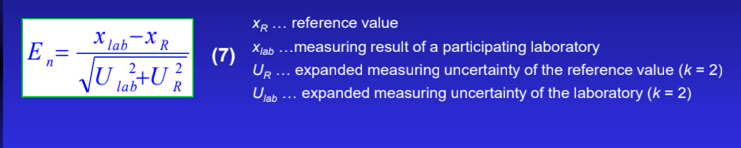

<br>$x_{lab}$ corresponds to the mean value at a specific frequency for the participating laboratory and
<br>$x_{ref}$ corresponds to the mean value at a specific frequency for the reference laboratory 
<br>$U_{lab}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for the participating laboratory 
<br>$U_{ref}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for the reference laboratory 
<br>If:<br> |En|<=1.1 - the criteria is satisfied (the original condition is that |En|<=1.0. However, because of the practical reasons, this limit is sometimes enlarged for 10%).
<br>|En|>1.1 - the criteria is not satisfied.
<br>One of the laboratories has been selected as a reference laboratory and other as a participating laboratory.This sequence is not important because it affects only the sign. That is why an absolute values are taken into account. 

The estimated value of the standard uncertainty is given by the standard deviation
of the mean

$$u(x)= s(\bar {x})$$

The expanded measurement uncertainty is calculated as:

$$U(x)= 2*u(x)$$


In [ ]:
#1
def calculate_En_values(df1,df2,df3,df4):
    En_values=np.empty((len(df1),2))

    En_values[:,0]=np.abs(((df1.iloc[:,1]-df2.iloc[:,1])/(2*(np.sqrt(df3.iloc[:,1]**2 +df4.iloc[:,1]**2)))))
    En_values[:,1]=np.abs(((df1.iloc[:,3]-df2.iloc[:,3])/(2*(np.sqrt(df3.iloc[:,3]**2 +df4.iloc[:,3]**2)))))
    #En_values[:,2]=np.abs(((df1.iloc[:,6]-df2.iloc[:,6])/(2*(np.sqrt(df3.iloc[:,6]**2 +df4.iloc[:,6]**2))))) 
    return En_values 

In [ ]:
En_values=calculate_En_values(avg_std_PTB,avg_std_CEM,st_sample_PTB,st_sample_CEM)

In [ ]:
En_values_df=pd.DataFrame(En_values, columns=["Magnitude","Phase"])#"Excitation amplitude")

In [ ]:
plt.figure(figsize=(8,10))
sns.heatmap(En_values_df, vmax=2, vmin=1.1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase"] )
plt.title("En values")


#excitation amp  - the en values does not have to be agreed because it is not targeted precisely

The calculated En values show disagreement of magnitudes at all frequencies, while good agreement of phase values is present in a range (12.5-20.0) Hz. Nevertheless, this approach is questionable when the test of variances from 2_ANOVA_for_experiments.ipynb is taken into account.

# References

[1] https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>[2] https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>[3] https://en.wikipedia.org/wiki/Effective_sample_size
<br>[4] https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>[5] https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/